# EEG Preprocessing  & Analysis Pipeline

Comprehensive pipeline for the *Reading‑Comprehension EEG* experiment, built with **MNE‑Python**.
It reads BrainVision  `.vhdr` files, cleans the data (filtering  +  ICA), extracts events, generates
epochs, visualises ERPs/PSD/TFR, and finishes with a simple machine‑learning classification
example.

> **Usage:** run each cell top‑to‑bottom after installing the required packages  
> `pip install mne scikit‑learn matplotlib numpy`


In [18]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# -------- File paths --------
SUBJECT = 'Subject_08'
RUN     = 'Fatigue_08'
root_dir = './experiment_data'
vhdr_fname = os.path.join(root_dir, SUBJECT, 'EEG', f'{RUN}.vhdr')

In [20]:
# -------- Load & inspect --------
raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True, verbose='error')

# Standard 10‑20 montage (modify if you used a custom cap)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='warn')

print(raw)
print(raw.info['ch_names'])

<RawBrainVision | Fatigue_08.eeg, 14 x 1667600 (1667.6 s), ~178.1 MB, data loaded>
['F3', 'Fz', 'F4', 'FC3', 'FCz', 'FC4', 'C3', 'C4', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']


In [21]:
# -------- Pre‑processing --------
# Band‑pass 1–40Hz and remove 50Hz line noise (plus harmonics)
raw.filter(l_freq=1., h_freq=40., fir_design='firwin')
raw.notch_filter(freqs=np.arange(50, 251, 50), fir_design='firwin')

# Optional — resample to speed up further steps
raw.resample(256, npad='auto')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



<RawBrainVision | Fatigue_08.eeg, 14 x 426906 (1667.6 s), ~45.6 MB, data loaded>

In [22]:
# -------- Artifact removal (ICA) --------
# Fit ICA on a 1Hz high‑passed copy (recommended by MNE devs)
ica_raw = raw.copy().filter(1., None)

ica = mne.preprocessing.ICA(n_components=14, max_iter='auto', random_state=42)
ica.fit(ica_raw)

# Detect ocular components (requires VEOG/HEOG or good proxies)
# eog_inds, eog_scores = ica.find_bads_eog(raw)
# ica.exclude = eog_inds
# print(f'Excluding ICA components: {ica.exclude}')

# Apply the ICA solution
ica.apply(raw)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 58.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components


/Users/rahul/miniconda3/envs/thesis-ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<RawBrainVision | Fatigue_08.eeg, 14 x 426906 (1667.6 s), ~45.6 MB, data loaded>

In [23]:
# -------- Persist cleaned data --------
clean_fname = os.path.join(root_dir, SUBJECT, 'EEG', f'{RUN}_cleaned_raw.fif')
raw.save(clean_fname, overwrite=True)

Writing /Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/experiment_data/Subject_08/EEG/Fatigue_08_cleaned_raw.fif
Closing /Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/experiment_data/Subject_08/EEG/Fatigue_08_cleaned_raw.fif
[done]


In [24]:
# -------- Events & epochs --------
events, event_id = mne.events_from_annotations(raw)
print('Original mapping:', event_id)

# Rename events to human‑readable keys — adjust to your marker scheme
rename_map = {
    'Response/R  1': 'stimulus',
    'Response/R  3': 'answer',
}
event_id = {new: event_id[old] for old, new in rename_map.items() if old in event_id}
print('Renamed mapping:', event_id)

# Epoching parameters
tmin, tmax   = -0.2, 0.8    # 200ms pre‑stimulus → 800ms post
baseline     = (None, 0)    # baseline‑correct using pre‑stimulus

epochs = mne.Epochs(raw, events, event_id,
                    tmin=tmin, tmax=tmax,
                    baseline=baseline,
                    event_repeated='merge',
                    preload=True)
print(epochs)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Response/R  3')]
Original mapping: {np.str_('New Segment/'): 99999, np.str_('Response/R  1'): 1001, np.str_('Response/R  3'): 1003}
Renamed mapping: {'stimulus': 1001, 'answer': 1003}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
98 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 98 events and 257 original time points ...
0 bad epochs dropped
<Epochs | 98 events (all good), -0.199 – 0.801 s (baseline -0.199 – 0 s), ~2.7 MB, data loaded,
 'stimulus': 48
 'answer': 48
 'answer/stimulus': 2>


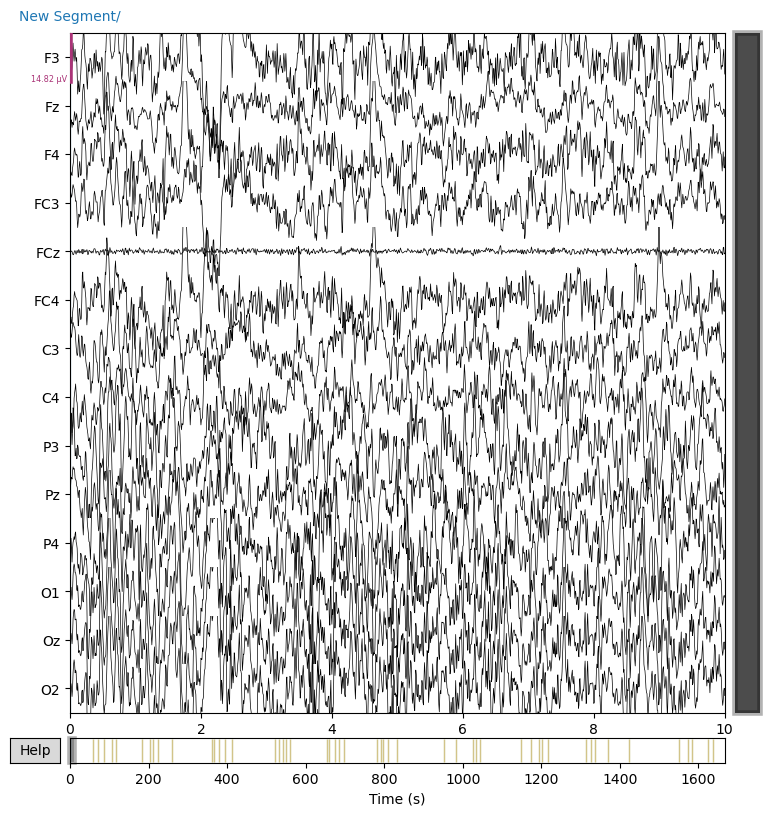

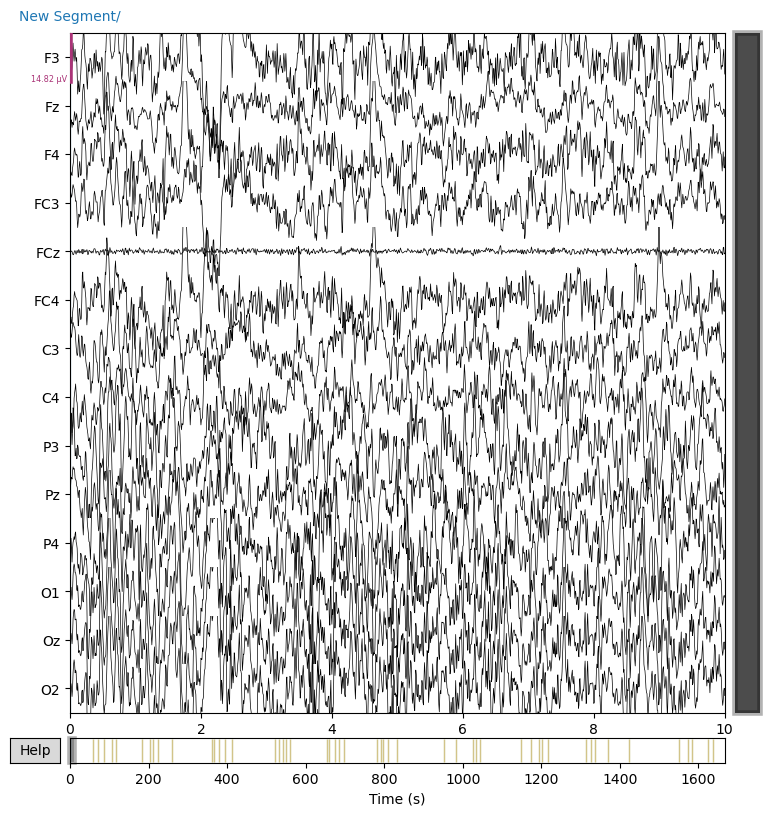

In [25]:
# -------- Quick visualisation --------
# Raw traces
raw.plot(n_channels=14, scalings='auto', title='Cleaned EEG')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Users/rahul/miniconda3/envs/thesis-ml/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


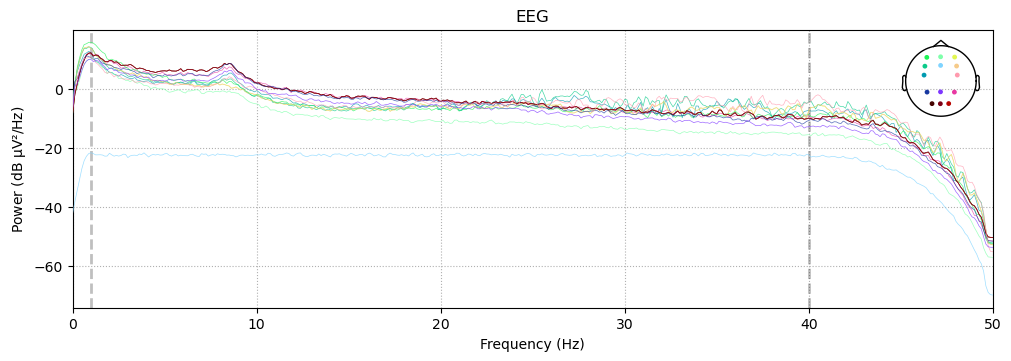

In [26]:
# Power spectral density
raw.plot_psd(fmax=50.0)

No projector specified for this dataset. Please consider the method self.add_proj.


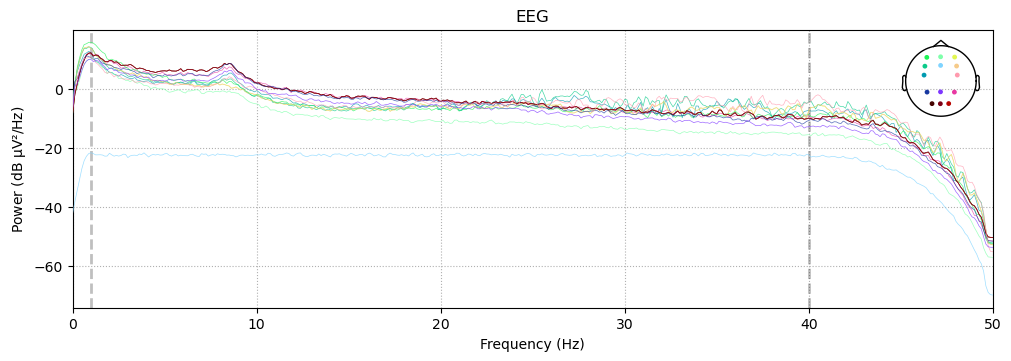

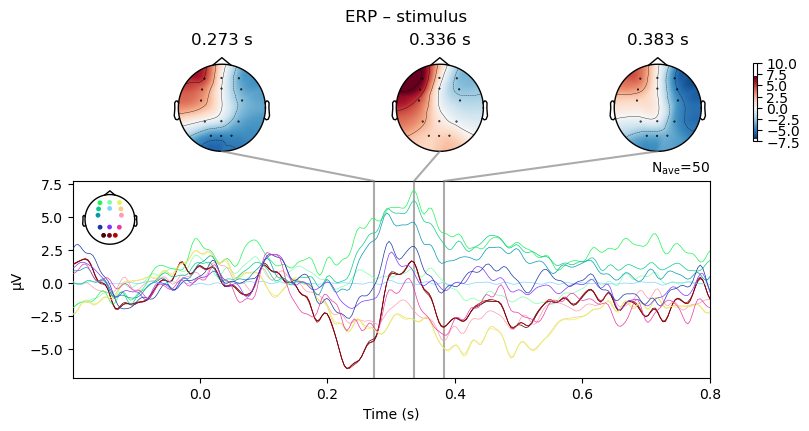

No projector specified for this dataset. Please consider the method self.add_proj.


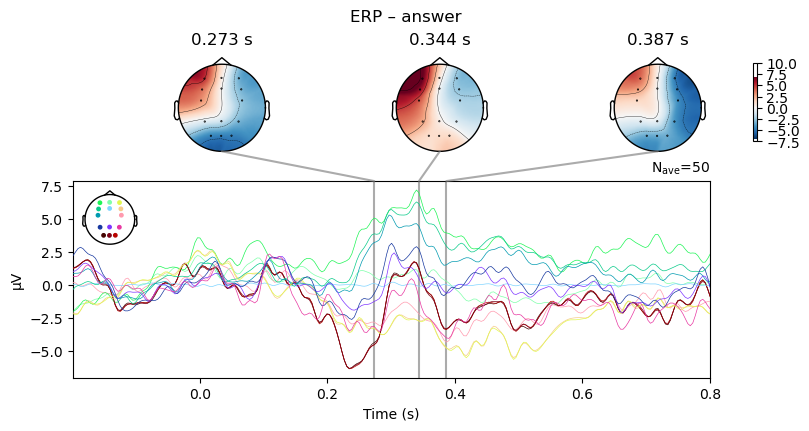

In [27]:
# Average ERPs
for cond in event_id:
    epochs[cond].average().plot_joint(title=f'ERP – {cond}')

Applying baseline correction (mode: zscore)


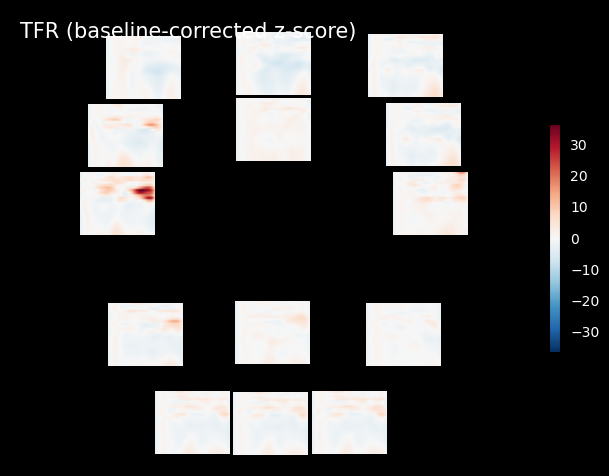

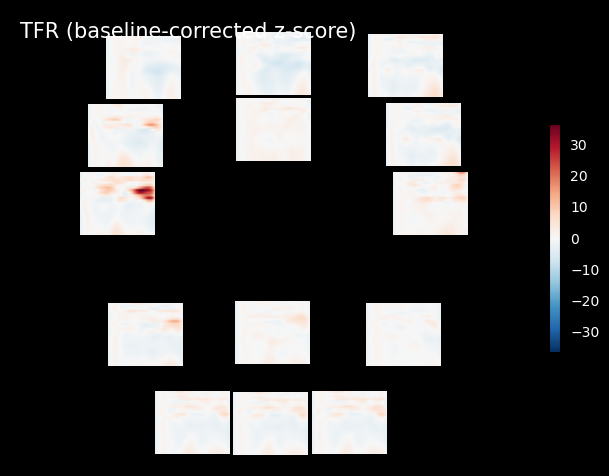

In [28]:
# -------- Time‑frequency analysis --------
from mne.time_frequency import tfr_morlet

freqs = np.logspace(np.log10(4), np.log10(40), num=25)
n_cycles = freqs / 2.

# power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles,
                   # return_itc=False, average=True)
power = epochs.compute_tfr(freqs=freqs, tmin=tmin, tmax=tmax, n_cycles=n_cycles, method='morlet', return_itc=False, average=True)

power.plot_topo(baseline=(-0.2, 0), mode='zscore',
                title='TFR (baseline‑corrected z‑score)')

Effective window size : 8.000 (s)
converting legacy list-of-tuples input to a dict for the `bands` parameter


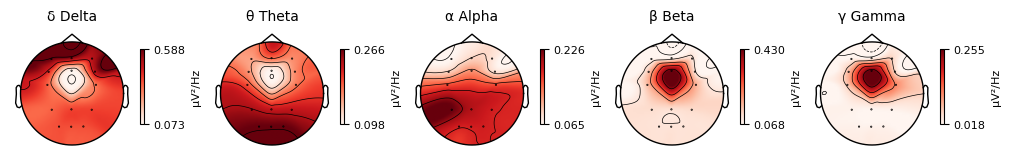

In [29]:
# topo map plotting

psd = raw.compute_psd(fmin=1, fmax=40, picks="eeg")
fig_psd = psd.plot_topomap(
    ch_type="eeg",
    normalize=True,
    bands=[
        (1, 4,  "δ Delta"),
        (4, 8,  "θ Theta"),
        (8, 13, "α Alpha"),
        (13, 30, "β Beta"),
        (30, 40, "γ Gamma"),
    ],
)
plt.show()

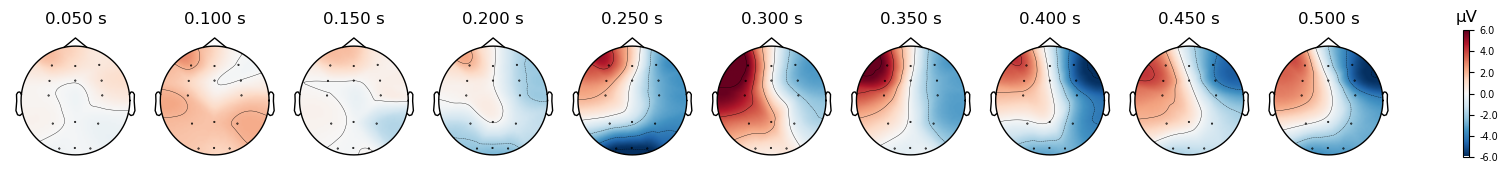

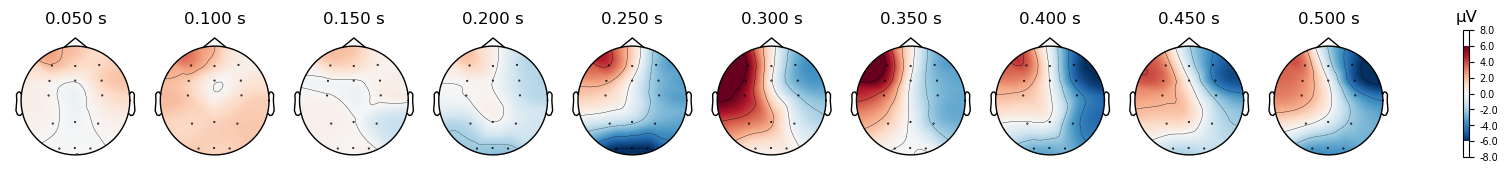

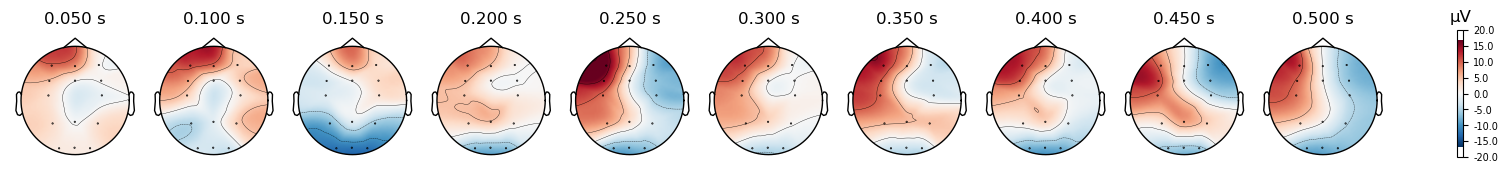

In [30]:
# voltage scalp topomaps
evokeds = {cond: epochs[cond].average() for cond in epochs.event_id.keys()}

# Select latencies of interest (here: 50–500 ms)
times = np.linspace(0.05, 0.50, 10)

for cond, ev in evokeds.items():
    ev.plot_topomap(
        times=times,
        ch_type="eeg",
        time_unit="s",
        outlines="head",        # nicer border
        sphere="auto",
    )

In [31]:
# -------- Feature extraction & ML --------
from mne.time_frequency import psd_array_welch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Frequency bands of interest
band_def = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 40),
}

X, y = [], []
for label, target in [('stimulus', 0), ('answer', 1)]:
    # check event labels, not channel types
    if label not in epochs.event_id:
        continue
    data = epochs[label].get_data()  # (n_epochs, n_ch, n_times)
    sfreq = epochs.info['sfreq']
    for ep in data:
        feats = []
        for fmin, fmax in band_def.values():
            bp = psd_array_welch(ep, sfreq,
                                 fmin=fmin, fmax=fmax,
                                 n_fft=256)[0].mean(-1) # mean over freqs
            feats.extend(bp)
        X.append(feats)
        y.append(target)

X = np.asarray(X)
y = np.asarray(y)
print('Feature matrix:', X.shape)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv)
print(f'Classification accuracy: {scores.mean():.2f} ± {scores.std():.2f}')

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [32]:
# -------- Save epochs & features --------
epochs_fname = os.path.join(root_dir, SUBJECT, 'EEG', f'{RUN}_epochs-epo.fif')
epochs.save(epochs_fname, overwrite=True)

np.save(os.path.join(root_dir, SUBJECT, 'EEG', f'{RUN}_features.npy'), X)
np.save(os.path.join(root_dir, SUBJECT, 'EEG', f'{RUN}_labels.npy'), y)